In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print('Available GPU: {0}'.format(len(gpus)))
tf.config.experimental.set_memory_growth(gpus[0], True)

Available GPU: 1


In [3]:
images_dir = Path('C:\\Users\\marwr\\PycharmProjects\\Tree-species\\Tree_images')

In [4]:
filepaths = list(images_dir.glob(r'**/*.jpeg'))
filepaths.extend(list(images_dir.glob(r'**/*.jpg')))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [5]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
image_df = images.sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
image_df["Label"].value_counts()

DĄB       1590
BRZOZA    1422
BUK       1414
JODŁA     1233
ŚWIERK    1231
OLSZA     1090
SOSNA      993
GRAB       974
Name: Label, dtype: int64

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input ,
    validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input ,
    validation_split=0.2)


In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (299,299),
    class_mode = 'categorical',
    batch_size=64,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (299,299),
    class_mode = 'categorical',
    batch_size=64,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (299,299),
    class_mode = 'categorical',
    batch_size=64,
    shuffle = False
)


Found 5570 validated image filenames belonging to 8 classes.
Found 1392 validated image filenames belonging to 8 classes.
Found 2985 validated image filenames belonging to 8 classes.


In [12]:
pretrained_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape = (299, 299, 3),
    include_top = False,
    weights = 'imagenet',
    classes = class_len,
    pooling = 'avg'
)

pretrained_model.trainable = False


In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(1536, activation = 'relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1536, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)


outputs = tf.keras.layers.Dense(class_len, activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 35, 35, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 64)  192         ['conv2d_11[0][0]']              
 ormalizat

 activation_21 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 35, 35, 48)   13824       ['activation_21[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 35, 35, 32)  96          ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 48)  144         ['conv2d_22[0][0]']              
 ormalizat

                                                                                                  
 activation_24 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activation_29 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_24[0][0]',          
                                                                  'activation_26[0][0]',          
                                                                  'activation_29[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 35, 35, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 activation_40 (Activation)     (None, 35, 35, 48)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_4_ac[0][0]']           
          

 block35_6_mixed (Concatenate)  (None, 35, 35, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 35, 35, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 35, 35, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
                                                                                                  
 block35_6_ac (Activation)      (None, 35, 35, 320)  0           ['block35_6[0][0]']              
          

 activation_58 (Activation)     (None, 35, 35, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 35, 35, 32)   9216        ['activation_55[0][0]']          
                                                                                                  
 conv2d_59 (Conv2D)             (None, 35, 35, 64)   27648       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_54 (BatchN  (None, 35, 35, 32)  96          ['conv2d_54[0][0]']              
 ormalization)                                                                                    
          

                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 35, 35, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_69 (Conv2D)             (None, 35, 35, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_69 (BatchN  (None, 35, 35, 32)  96          ['conv2d_69[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 35, 35, 32)   0           ['batch_normalization_69[0][0]'] 
          

 activation_75 (Activation)     (None, 17, 17, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 17, 17, 1088  0           ['activation_72[0][0]',          
                                )                                 'activation_75[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_77 (Conv2D)             (None, 17, 17, 128)  139264      ['mixed_6a[0][0]']               
                                                                                                  
 batch_nor

                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 17, 17, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 17, 17, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_normalization_85 (BatchN  (None, 17, 17, 128)  384        ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 17, 17, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 17, 17, 128)  384        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_93 (Activation)     (None, 17, 17, 128)  0           ['batch_normalization_93[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 17, 17, 160)  143360      ['activation_93[0][0]']          
          

                                                                                                  
 batch_normalization_101 (Batch  (None, 17, 17, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_101[0][0]']
                                                                                                  
 conv2d_102 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_101[0][0]']         
                                                                                                  
 batch_normalization_102 (Batch  (None, 17, 17, 160)  480        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_109 (Activation)    (None, 17, 17, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_normalization_110 (Batch  (None, 17, 17, 160)  480        ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_110 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_110[0][0]']
                                                                                                  
 conv2d_10

 conv2d_118 (Conv2D)            (None, 17, 17, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 17, 17, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_118 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_116 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_10_ac[0][0]']          
                                                                                                  
 conv2d_119 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_118[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_127 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_126[0][0]']         
                                                                                                  
 batch_normalization_124 (Batch  (None, 17, 17, 192)  576        ['conv2d_124[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_132 (Conv2D)            (None, 17, 17, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_normalization_132 (Batch  (None, 17, 17, 192)  576        ['conv2d_132[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_135 (Batch  (None, 17, 17, 192)  576        ['conv2d_135[0][0]']             
 Normalization)                                                                                   
          

 conv2d_143 (Conv2D)            (None, 17, 17, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 17, 17, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_143 (Batch  (None, 17, 17, 192)  576        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_140 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 activatio

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 17, 17, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 activation_151 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_151[0][0]']
                                                                                                  
 block17_19_mixed (Concatenate)  (None, 17, 17, 384)  0          ['activation_148[0][0]',         
          

 activation_156 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_156[0][0]']
                                                                                                  
 activation_158 (Activation)    (None, 17, 17, 256)  0           ['batch_normalization_158[0][0]']
                                                                                                  
 activation_161 (Activation)    (None, 17, 17, 288)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_157 (Conv2D)            (None, 8, 8, 384)    884736      ['activation_156[0][0]']         
                                                                                                  
 conv2d_159 (Conv2D)            (None, 8, 8, 288)    663552      ['activation_158[0][0]']         
                                                                                                  
 conv2d_16

                                                                                                  
 activation_169 (Activation)    (None, 8, 8, 224)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 conv2d_167 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_1_ac[0][0]']            
                                                                                                  
 conv2d_170 (Conv2D)            (None, 8, 8, 256)    172032      ['activation_169[0][0]']         
                                                                                                  
 batch_normalization_167 (Batch  (None, 8, 8, 192)   576         ['conv2d_167[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 batch_normalization_175 (Batch  (None, 8, 8, 192)   576         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_178 (Batch  (None, 8, 8, 256)   768         ['conv2d_178[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_175 (Activation)    (None, 8, 8, 192)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_178 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 block8_4_

                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 256)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 block8_6_mixed (Concatenate)   (None, 8, 8, 448)    0           ['activation_183[0][0]',         
                                                                  'activation_186[0][0]']         
                                                                                                  
 block8_6_conv (Conv2D)         (None, 8, 8, 2080)   933920      ['block8_6_mixed[0][0]']         
                                                                                                  
 block8_6 (Lambda)              (None, 8, 8, 2080)   0           ['block8_5_ac[0][0]',            
                                                                  'block8_6_conv[0][0]']          
          

                                                                                                  
 block8_8 (Lambda)              (None, 8, 8, 2080)   0           ['block8_7_ac[0][0]',            
                                                                  'block8_8_conv[0][0]']          
                                                                                                  
 block8_8_ac (Activation)       (None, 8, 8, 2080)   0           ['block8_8[0][0]']               
                                                                                                  
 conv2d_196 (Conv2D)            (None, 8, 8, 192)    399360      ['block8_8_ac[0][0]']            
                                                                                                  
 batch_normalization_196 (Batch  (None, 8, 8, 192)   576         ['conv2d_196[0][0]']             
 Normalization)                                                                                   
          

 )                                                                                                
                                                                                                  
 conv_7b_ac (Activation)        (None, 8, 8, 1536)   0           ['conv_7b_bn[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['conv_7b_ac[0][0]']             
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 1536)         2360832     ['global_average_pooling2d[0][0]'
                                                                 ]                                
                                                                                                  
 dropout (

In [14]:
model.compile(
    optimizer = Adam(learning_rate = 0.002),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

earlystopper = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, 
                           verbose=1, mode='max', min_lr=0.00001)



filepath="InceptionResNetV2_64_dropout_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
log_csv = CSVLogger('InceptionResNetV2_64_dropout_less_photo_logs.csv', separator=',', append=False)
# Save the best model during the traning


start = time.time()

history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 30,
    callbacks=[earlystopper, reduce_lr, checkpoint, log_csv]
)

end = time.time()
model.save('InceptionResNetV2_64_dropout_less_photo.h5') 

Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 1.0473 - accuracy: 0.6926
Epoch 1: val_accuracy improved from -inf to 0.87428, saving model to InceptionResNetV2_64_dropout_models\weights-improvement-01-0.87.hdf5
88/88 [==============================] - 768s 9s/step - loss: 1.0473 - accuracy: 0.6926 - val_loss: 0.3691 - val_accuracy: 0.8743 - lr: 0.0020
Epoch 2/30
88/88 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.8488
Epoch 2: val_accuracy did not improve from 0.87428
88/88 [==============================] - 738s 8s/step - loss: 0.4456 - accuracy: 0.8488 - val_loss: 0.4351 - val_accuracy: 0.8369 - lr: 0.0020
Epoch 3/30
88/88 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.8706
Epoch 3: val_accuracy improved from 0.87428 to 0.91307, saving model to InceptionResNetV2_64_dropout_models\weights-improvement-03-0.91.hdf5
88/88 [==============================] - 742s 8s/step - loss: 0.3878 - accuracy: 0.8706 - val_loss: 0.

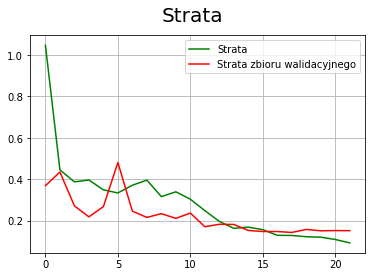

In [15]:
#loss anc validation loss
fig = plt.figure()
plt.plot(history.history['loss'], color='green',label='Strata')
plt.plot(history.history['val_loss'], color='red',label='Strata zbioru walidacyjnego')
fig.suptitle('Strata', fontsize=20)
plt.legend(loc="upper right")
plt.grid(visible=True)

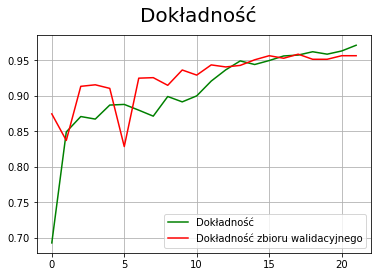

In [16]:
#accuracy and validation accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='green',label='Dokładność')
plt.plot(history.history['val_accuracy'], color='red',label='Dokładność zbioru walidacyjnego')
fig.suptitle('Dokładność', fontsize=20)
plt.legend(loc="lower right")
plt.grid(visible=True)

In [17]:
results = model.evaluate(test_images, verbose=0)
print("Test accuracy {:.2f}%".format(results[1]*100))

Test accuracy 95.58%


In [18]:
predictions = np.argmax(model.predict(test_images), axis = 1)


cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names = test_images.class_indices)

47/47 [==============================] - 299s 6s/step


In [21]:
test_images.class_indices

{'BRZOZA': 0,
 'BUK': 1,
 'DĄB': 2,
 'GRAB': 3,
 'JODŁA': 4,
 'OLSZA': 5,
 'SOSNA': 6,
 'ŚWIERK': 7}

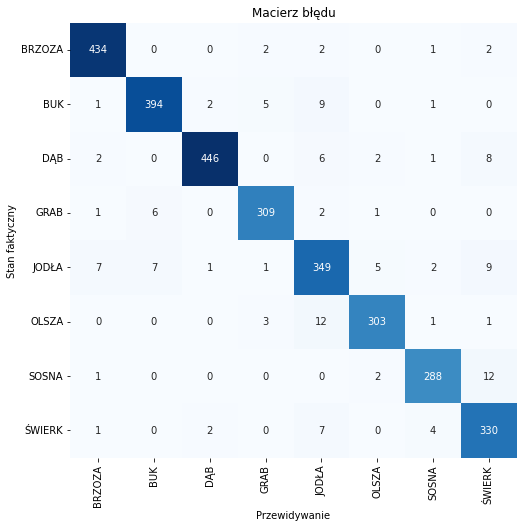

In [22]:
plt.figure(figsize=(class_len,class_len))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(ticks=np.arange(class_len)+.5, labels = test_images.class_indices, rotation= 90)
plt.yticks(ticks=np.arange(class_len)+.5, labels = test_images.class_indices, rotation=0)
plt.xlabel("Przewidywanie")
plt.ylabel("Stan faktyczny")
plt.title("Macierz błędu")
plt.show()

In [23]:
print("Classification Report:\n----------------------\n", clr) 

Classification Report:
----------------------
               precision    recall  f1-score   support

      BRZOZA       0.97      0.98      0.98       441
         BUK       0.97      0.96      0.96       412
         DĄB       0.99      0.96      0.97       465
        GRAB       0.97      0.97      0.97       319
       JODŁA       0.90      0.92      0.91       381
       OLSZA       0.97      0.95      0.96       320
       SOSNA       0.97      0.95      0.96       303
      ŚWIERK       0.91      0.96      0.93       344

    accuracy                           0.96      2985
   macro avg       0.96      0.96      0.96      2985
weighted avg       0.96      0.96      0.96      2985



In [24]:
print('Czas obliczenia {:.2f} minutes'.format((end-start)/60))

Czas obliczenia 268.78 minutes


In [34]:
class_names_list = ['Brzoza', 'Buk', 'Dąb','Grab' ,'Jodła', 'Olsza', 'Sosna', 'Świerk']

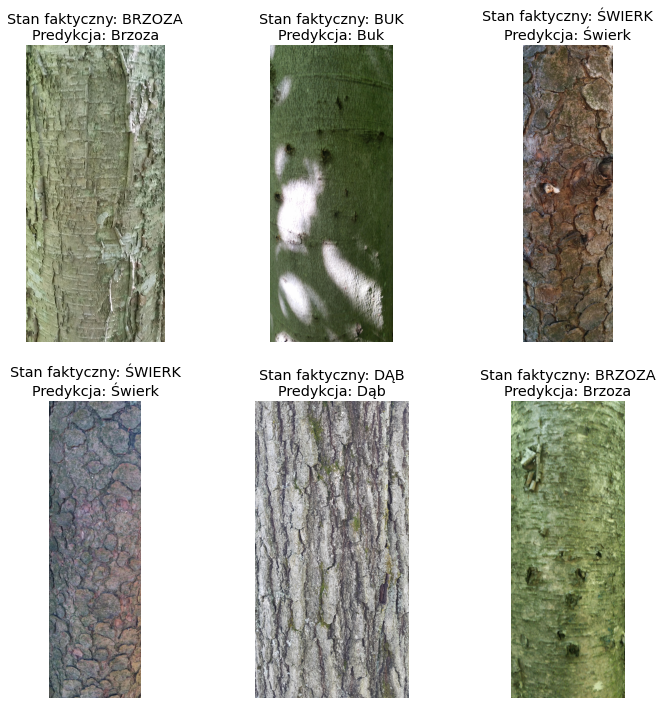

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(12, 12))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    PATH = test_df.iloc[320+i,0]
    image = mpimg.imread(PATH) # images are color images
    #plt.title(class_names_list[predictions[i]])
    plt.title('Stan faktyczny: ' + test_df.iloc[320+i,1] + '\nPredykcja: ' + class_names_list[predictions[320+i]] )
    plt.axis('off')
    plt.imshow(image)